In [1]:
%run util.py

In [2]:
data_folder = '/home/jzh/Waze/'

In [3]:
import json

In [4]:
# Loading PL data
PL_dict = zload(data_folder + 'PL_dict.pkz') 

In [5]:
# PL_dict

In [6]:
mu_1 = PL_dict['PL_AM']  # normal PL for AM period
mu_2 = PL_dict['PL_MD']  # normal PL for MD period
mu_3 = PL_dict['PL_PM']  # normal PL for PM period
mu_4 = PL_dict['PL_NT']  # normal PL for NT period

mu_1 = mu_adjust(mu_1)  # normal PL
mu_01, mu1, mu_11, P1, G_11, H_11, U_11 = ChainGen_(mu_1)

mu_2 = mu_adjust(mu_2)  # normal PL
mu_02, mu2, mu_12, P2, G_12, H_12, U_12 = ChainGen_(mu_2)

mu_3 = mu_adjust(mu_3)  # normal PL
mu_03, mu3, mu_13, P3, G_13, H_13, U_13 = ChainGen_(mu_3)

mu_4 = mu_adjust(mu_4)  # normal PL
mu_04, mu4, mu_14, P4, G_14, H_14, U_14 = ChainGen_(mu_4)

<string>:486: RuntimeWarning: covariance is not positive-semidefinite.


In [7]:
beta = 1e-6
G_list = [G_11, G_12, G_13, G_14]
H_list = [H_11, H_12, H_13, H_14]
U_list = [U_11, U_12, U_13, U_14]

eta_wc = {}
eta_Sanov = {}

# Get thresholds for Hoeffding's test corresponding to sample length n  
def etaWC(n):
    return HoeffdingRuleMarkovRobust_(beta, G_list, H_list, U_list, n)

In [8]:
# Loading test data

with open(data_folder + 'sample_path_jam_test_data_sorted_trans.json', 'r') as json_file:
    sample_path_jam_test_data_sorted_trans = json.load(json_file)

In [9]:
sample_path_jam_test_data_sorted_trans['0']

{u'alphaTrans': 78.0,
 u'startTime': 300.0105,
 u'uuid': [u'2a0ee22c-6229-3863-a362-8a5e0be020e4',
  u'd836e23a-c958-37a7-b126-c70258b61a7a']}

In [10]:
i = 0  # index of windows
sam_gap = 120
win_size = 600
win_list = []
while i * sam_gap + win_size < 24 * 3600:
    win_list.append((i * sam_gap, i * sam_gap + win_size))
    i += 1

In [11]:
i

715

In [12]:
win_num = len(win_list)
jam_num = len(sample_path_jam_test_data_sorted_trans)

win_jam = {}
for i in range(win_num):
    key = str(i)
    value = []
    for j in range(jam_num):
        if ((sample_path_jam_test_data_sorted_trans[str(j)]['startTime'] >= win_list[i][0]) \
            and (sample_path_jam_test_data_sorted_trans[str(j)]['startTime'] < win_list[i][1])):
            value.append(str(j))
    win_jam[key] = value

In [13]:
win_jam['714'], win_list[714][0], win_num 

(['3857',
  '3858',
  '3859',
  '3860',
  '3861',
  '3862',
  '3863',
  '3864',
  '3865',
  '3866',
  '3867',
  '3868',
  '3869',
  '3870',
  '3871',
  '3872',
  '3873',
  '3874',
  '3875',
  '3876',
  '3877',
  '3878',
  '3879',
  '3880'],
 85680,
 715)

In [14]:
sample_path_jam_test_data_sorted_trans[win_jam['100'][0]]['startTime']

12300.0027

In [15]:
KL_list = []  # The list of the KL divergences; each is for a detection window
etaWC_list = []
for i in range(win_num):
    sample_path_jam = [sample_path_jam_test_data_sorted_trans[key]['alphaTrans'] for key in win_jam[str(i)]]
    n = len(sample_path_jam)
    if (n != 0):
        etaWC_list.append(etaWC(n))
        KL_1 = KL_est(sample_path_jam, mu_1)
        KL_2 = KL_est(sample_path_jam, mu_2)
        KL_3 = KL_est(sample_path_jam, mu_3)
        KL_4 = KL_est(sample_path_jam, mu_4)
        KL_list.append(min([KL_1, KL_2, KL_3, KL_4]))
    else:
        etaWC_list.append(1e-6)
        KL_list.append(0)

In [16]:
win_jam[str(100)], win_list[100][1]

(['233', '234', '235', '236', '237', '238', '239'], 12600)

In [17]:
%matplotlib inline

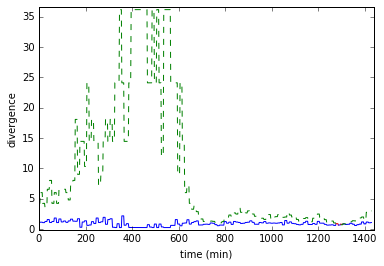

In [18]:
time_range = [win_list[i][0] / 60.0 for i in range(win_num)]
plot_points(time_range, KL_list, etaWC_list)
plt.ylabel('divergence')
plt.xlabel('time (min)')
pylab.ylim(-0.1, max(etaWC_list)+0.5)
pylab.xlim(0, max(time_range) + 10)
plt.savefig(data_folder + 'detec_results_WC_robust.pdf')

In [19]:
len(time_range), len(KL_list), len(etaWC_list), time_range[0:2]

(715, 715, 715, [0.0, 2.0])

In [20]:
potential_ano_list = []
for i in range(len(KL_list)):
    if KL_list[i] > etaWC_list[i]:
        for j in range(len(win_jam[str(i)])):
            potential_ano_list.append(win_jam[str(i)][j])

In [21]:
with open(data_folder + 'sample_path_jam_test_data_sorted.json', 'r') as json_file:
    sample_path_jam_test_data_sorted = json.load(json_file)

In [22]:
sample_path_jam_test_data_sorted['2917']

{u'alpha': 10.0,
 u'length': 254.0,
 u'numPts': 12.0,
 u'speed': 1.025,
 u'startTime': 76500.1784,
 u'uuid': u'8565d7a9-74d1-37aa-bd2e-f327cbbcfc86'}

In [23]:
len(set(potential_ano_list)), set(potential_ano_list)

(186,
 {'2959',
  '2960',
  '2961',
  '2962',
  '2963',
  '2964',
  '2965',
  '2966',
  '2967',
  '2968',
  '2969',
  '2970',
  '2971',
  '2972',
  '2973',
  '2974',
  '2975',
  '2976',
  '2977',
  '2978',
  '2979',
  '2980',
  '2981',
  '2982',
  '2983',
  '2984',
  '2985',
  '2986',
  '2987',
  '2988',
  '2989',
  '2990',
  '2991',
  '2992',
  '2993',
  '2994',
  '2995',
  '2996',
  '2997',
  '2998',
  '2999',
  '3000',
  '3001',
  '3002',
  '3003',
  '3004',
  '3005',
  '3006',
  '3007',
  '3008',
  '3009',
  '3010',
  '3011',
  '3012',
  '3013',
  '3014',
  '3015',
  '3016',
  '3017',
  '3018',
  '3019',
  '3020',
  '3021',
  '3022',
  '3023',
  '3024',
  '3025',
  '3026',
  '3027',
  '3028',
  '3029',
  '3030',
  '3031',
  '3032',
  '3033',
  '3034',
  '3035',
  '3036',
  '3037',
  '3038',
  '3039',
  '3040',
  '3041',
  '3042',
  '3043',
  '3044',
  '3045',
  '3133',
  '3134',
  '3135',
  '3136',
  '3137',
  '3138',
  '3139',
  '3140',
  '3141',
  '3142',
  '3143',
  '3144',
  '3

In [24]:
len(sample_path_jam_test_data_sorted_trans)

3881

In [25]:
# Refine the detection results; if a jam's length is larger than 1 km,
# then the jam is "indeed" abnormal.
ano_list = []
for key in set(potential_ano_list):
    if (sample_path_jam_test_data_sorted[key]['length'] > 1000):
        ano_list.append(key)

In [26]:
len(ano_list), ano_list

(16,
 ['2964',
  '2963',
  '3034',
  '3033',
  '3035',
  '3149',
  '2989',
  '3021',
  '3005',
  '3000',
  '3212',
  '2959',
  '3205',
  '2979',
  '3223',
  '3198'])

In [27]:
for key in potential_ano_list:
    if (sample_path_jam_test_data_sorted[key]['startTime'] > 69900 and 
        sample_path_jam_test_data_sorted[key]['startTime'] < 69901):
        uuid = sample_path_jam_test_data_sorted[key]['uuid']
        print(points_dict_Mar16[uuid][0][2])

In [28]:
with open(data_folder + '/points_dict_Mar16_comp.json', 'r') as json_file:
    points_dict_Mar16_comp = json.load(json_file)

In [29]:
points_dict_Mar16_comp['50a5d058-2b16-3034-bd41-623f96b2829a']

[[[-71.123535, 42.334441],
  [-71.12364, 42.334329],
  [-71.12384, 42.33408],
  [-71.124185, 42.333598],
  [-71.124659, 42.33294],
  [-71.12478, 42.332789],
  [-71.12535, 42.33198],
  [-71.125498, 42.331798],
  [-71.125729, 42.33141],
  [-71.12573, 42.33141],
  [-71.125835, 42.331218],
  [-71.12595, 42.330951],
  [-71.126026, 42.330675],
  [-71.126057, 42.330385],
  [-71.126085, 42.330063]],
 15]

In [30]:
('-71.128121', '42.359786', 'ACCIDENT', 68700.0, '2016-03-16 19:06:00.000')


('-71.128121', '42.359786', 'ACCIDENT', 68700.0, '2016-03-16 19:06:00.000')

In [31]:
jam1 = [42.359786, -71.128121]

In [32]:
jam2 = [42.363025, -71.13641] 

In [33]:
from geopy.distance import vincenty
vincenty(jam1, jam2).meters

771.8372664016924